In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

# SDPD Traffic Stops Data: initial EDA

This notebook contains an initial exploratory data analysis of SD police traffic stops data from 2016. It contains just enough analyses to inform the data cleaning process, for further statistical analyses later. This involves:
* Making sure data types match the expected values for each column,
* Cleaning any obvious outliers and fields with placeholder values for NULL,
* Collapsing values to a precision that better reflects the data collection process.

In [2]:
stops = pd.read_csv('http://seshat.datasd.org/pd/vehicle_stops_2016_datasd.csv')

# Quality of attributes

---

## Quality of `stop_id`
* a few records have duplicate IDs.
* The stops for the duplicate IDs are unrelated.
* Cleaning should create a new index; (keep `stop_id` for joining with search details)

In [3]:
# duplicate stop ids
stops.stop_id.duplicated().mean()

9.70393300404654e-05

In [4]:
stops.loc[stops.stop_id.duplicated(keep=False)].sort_values(by='stop_id').head()

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,timestamp,stop_date,stop_time,sd_resident,arrested,searched,obtained_consent,contraband_found,property_seized
14030,1325336,Moving Violation,520,H,M,24,2016-02-13 23:55:00,2016-02-13,23:55,Y,N,N,NaN,NaN,NaN
17233,1325336,Equipment Violation,830,H,M,61,2016-02-24 00:00:00,2016-02-24,0:00,Y,N,N,NaN,NaN,NaN
19374,1330010,Moving Violation,120,B,F,51,2016-03-01 10:15:00,2016-03-01,10:15,NaN,n,n,,,
22071,1330010,Moving Violation,320,W,F,25,2016-03-09 11:23:00,2016-03-09,11:23,Y,N,N,NaN,NaN,NaN
22106,1330041,Moving Violation,120,W,F,62,2016-03-09 12:50:00,2016-03-09,12:50,Y,n,n,NaN,NaN,NaN


## Quality of `timestamp`, `stop_date`, `stop_time`

* timestamp is clean, but is NULL when a *time* doesn't exist.
* stop_date seems valid for every entry.
* few enough timestamps are corrupt to matter; drop NULL.

In [5]:
stops.timestamp.isnull().mean()

0.001669076476696005

In [9]:
stops['timestamp'] = pd.to_datetime(stops.timestamp)

#stops = stops.dropna(subset=['timestamp'])

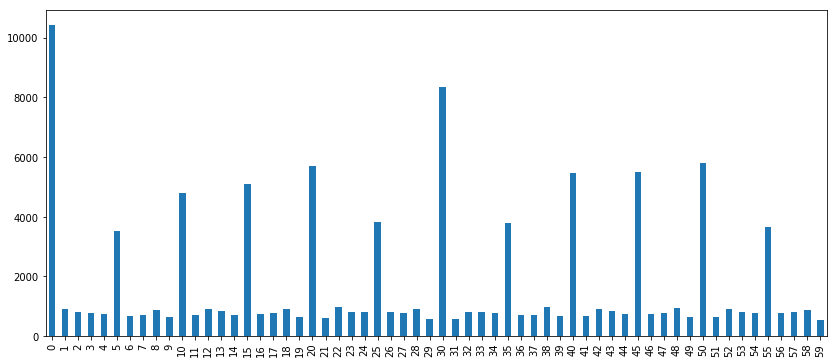

In [91]:
times.apply(lambda x:x.minute).value_counts().sort_index().plot(kind='bar', figsize=(14,6))

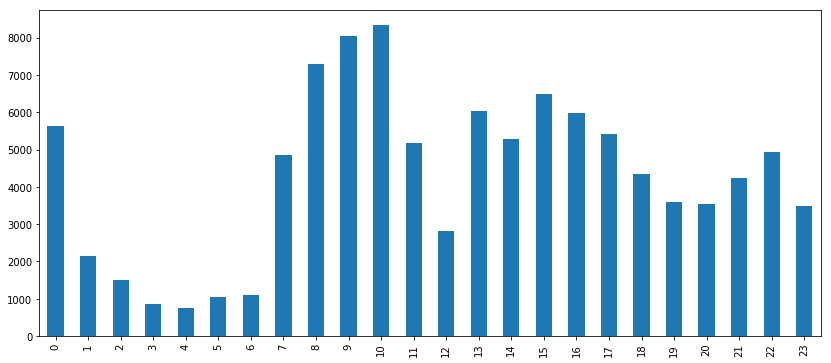

In [92]:
times.apply(lambda x:x.hour).value_counts().sort_index().plot(kind='bar', figsize=(14,6))

## Quality of stop-attributes

* `stop_cause`: the investigation is on overall causes/effects of traffic stops, so can likely NULL all but Moving/Equipment,
* `service_area`: 'Unknown' is NULL; other fields are reasonable in form.
    - Service areas `530`, `840`, `130`, and `630` have few stops; data quality issue?
* `subject_race`: Look fine; perhaps group certain classifications together?
* `subject_sex`: `X` is different than `NaN`, however, `NaN` likely contains what *should* be `X`. Non-binary classifications are likely unreliable. Group them together.
* `subject_age`: Three issues with data quality.
    - `No Age`, `0` are both placeholders for `NaN`.
    - ages beyond `100` are likely recording errors,
    - ages less than `14` are likely recording errors.

In [98]:
attr_cols = ['stop_cause', 'service_area', 'subject_race', 'subject_sex', 'subject_age', 'sd_resident']

In [95]:
stops.stop_cause.value_counts(normalize=True, dropna=False)

Moving Violation                      0.729303
Equipment Violation                   0.254979
Radio Call/Citizen Contact            0.005550
Muni, County, H&S Code                0.003101
Personal Knowledge/Informant          0.002809
No Cause Specified on a Card          0.001789
Suspect Info (I.S., Bulletin, Log)    0.001759
Personal Observ/Knowledge             0.000437
MUNI, County, H&S Code                0.000136
NaN                                   0.000068
Suspect Info                          0.000019
Bicycle                               0.000019
BICYCLE                               0.000010
B & P                                 0.000010
Bicycle Bicycle                       0.000010
Name: stop_cause, dtype: float64

In [99]:
stops.service_area.value_counts()

120        8157
310        8062
520        7889
710        7829
110        7245
930        6758
240        6424
230        5593
510        4933
320        4709
620        4463
610        4343
720        4244
440        4172
430        4011
Unknown    3908
810        3514
830        3364
820        3028
530         171
840          24
130          23
630          15
Name: service_area, dtype: int64

In [100]:
stops.subject_race.value_counts()

W    42247
H    32402
B    11828
O     7891
A     4765
F     1225
V      621
C      537
I      479
X      167
K      136
P      110
J       98
Z       72
L       54
D       50
S       37
G       22
U        7
Name: subject_race, dtype: int64

In [191]:
stops.subject_sex.value_counts(dropna=False)

M      67167
F      35516
NaN      186
X         10
Name: subject_sex, dtype: int64

In [126]:
stops.loc[~stops.subject_age.fillna('0').str.isdigit(), 'subject_age'].unique()

array(['No Age'], dtype=object)

In [128]:
stops['subject_age'] = pd.to_numeric(stops.subject_age, errors='coerce')

In [136]:
stops.loc[(stops.subject_age < 16) | (stops.subject_age > 100), 'subject_age'].value_counts().sort_index()

0.0      218
1.0        2
2.0        6
4.0        4
5.0        1
6.0        1
9.0        1
10.0       2
14.0       5
15.0      27
114.0      1
119.0      1
120.0      1
145.0      1
163.0      1
212.0      1
220.0      1
Name: subject_age, dtype: int64

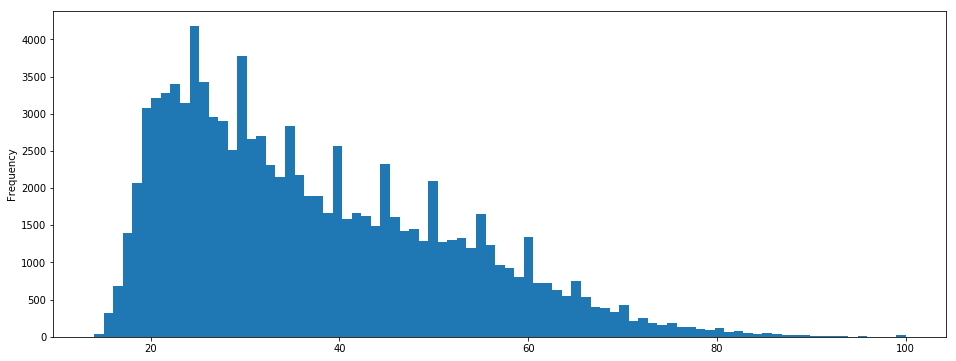

In [140]:
stops.loc[(stops.subject_age >= 14)&(stops.subject_age <= 100), 'subject_age'].plot(kind='hist', bins=85, figsize=(16,6))

In [141]:
stops.sd_resident.value_counts()

Y    61986
N    21531
         1
Name: sd_resident, dtype: int64

## Quality of stop actions

In [146]:
actions = ['arrested', 'searched', 'obtained_consent', 'contraband_found',
       'property_seized']

In [150]:
for c in actions:
    print(
        c, '\n', stops[c].value_counts(dropna=False).to_string(), end='\n\n'
    )

arrested 
 N      82915
NaN    18650
Y       1239
n         73
y          1
           1

searched 
 N      79115
NaN    19719
Y       3969
n         74
\          1
           1

obtained_consent 
 NaN    98091
N       4741
Y         45
           2

contraband_found 
 NaN    97913
N       4482
Y        482
           2

property_seized 
 NaN    97958
N       4385
Y        534
           2

